In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install scanpy
!pip install scvelo
!pip install scikit-misc

In [81]:
import scanpy as sc
import scvelo as scv
import os
from anndata import AnnData as ad
import pandas as pd

Read dataset

In [82]:
adata = scv.datasets.dentategyrus_lamanno("../datasets/raw/dentategyrus.loom")
'''ad.write_h5ad(adata, "dentategyrus_raw_data.h5ad")'''

'ad.write_h5ad(adata, "dentategyrus_raw_data.h5ad")'

In [83]:
#adata=sc.read_h5ad('/content/drive/MyDrive/dentategyrus_raw_data.h5ad')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Save counts

In [84]:
adata.layers["X_counts"] = adata.X.copy()

HVG selection

In [85]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="X_counts",
    subset=True,
)

In [86]:
# normalize to 10k reads per cell
sc.pp.normalize_total(adata, target_sum=10000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
adata.X.sum(1)

matrix([[10000.   ],
        [10000.001],
        [10000.   ],
        ...,
        [ 9999.999],
        [10000.   ],
        [10000.   ]], dtype=float32)

Preprocess

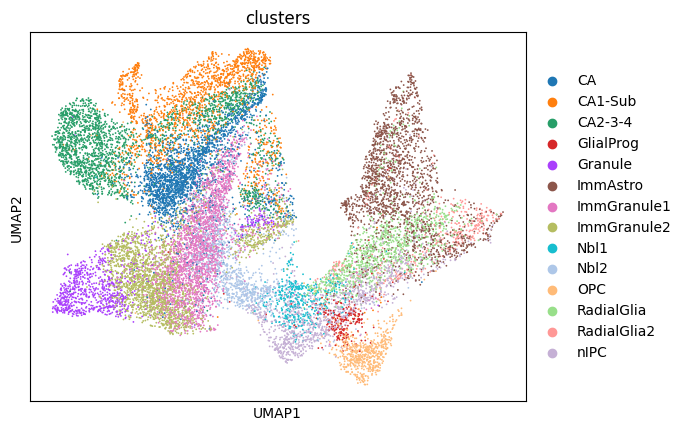

In [88]:
#sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["clusters"])

In [89]:
adata.obs = adata.obs.rename({"clusters": "cell_type"})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
# change the column name "clusters" to "cluster"
columns_names = list(adata.obs.columns)
index_of_clusters = columns_names.index("clusters")
columns_names[index_of_clusters] = "cluster"
adata.obs.columns=columns_names

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
# change the categories to numbers
num_categories = adata.obs['cluster'].nunique()
new_categories = np.arange(num_categories)
adata.rename_categories('cluster', new_categories)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
import numpy as np
# Testing samples should be randomly chosen considering cell ratios in each cluster ('balanced split')'
# add an obs "split"
adata.obs['split']='train'

# function for "balanced split"
for i in range(num_categories):
    cluster_indices = list(adata.obs_names[adata.obs['cluster'] == i])
    # Choose 10% of the numbers randomly
    percentage_to_choose = 0.10
    number_to_choose = int(len(cluster_indices) * percentage_to_choose)
    randomly_chosen_numbers = np.random.choice(len(cluster_indices), number_to_choose, replace=False)
    index_test = np.array(cluster_indices)[randomly_chosen_numbers]

    # split the data for this class i, train:test=9:1
    adata.obs.loc[index_test, 'split'] = 'test'

# print number of training data and test data
print('training data:', np.sum((np.array(adata.obs['split']) == 'train')))
print('test data:', np.sum((np.array(adata.obs['split']) == 'test')))

training data: 16399
test data: 1814


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
adata

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AnnData object with n_obs × n_vars = 18213 × 2000
    obs: 'Age', 'cluster', 'split'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_tsne', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'X_counts'
    obsp: 'distances', 'connectivities'

In [94]:
adata.X.sum(1)

matrix([[10000.   ],
        [10000.001],
        [10000.   ],
        ...,
        [ 9999.999],
        [10000.   ],
        [10000.   ]], dtype=float32)

Save

In [95]:
ad.write_h5ad(adata, '/content/drive/MyDrive/dentategyrus_preprocessed.h5ad')

In [96]:
adata.obs["lib_size"] = adata.layers["X_counts"].A.sum(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
adata.obs.lib_size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CellID
10X83_2:AAACGGGGTCTCTTTAx    1382.0
10X83_2:AACCATGGTTCAACCAx    1308.0
10X83_2:AACACGTTCTGAAAGAx    3705.0
10X83_2:AAAGATGCATTGAGCTx     671.0
10X83_2:AACCATGTCTACTTACx     795.0
                              ...  
10X84_3:TTTCCTCCACCATCCTx     473.0
10X84_3:TTTGTCACATGAAGTAx    4695.0
10X84_3:TTTCCTCCACGGTAAGx     635.0
10X84_3:TTTGTCAAGCGTCAAGx     536.0
10X84_3:TTTCCTCGTGAAAGAGx     439.0
Name: lib_size, Length: 18213, dtype: float32

In [98]:
adata.obs.groupby("cluster").lib_size.mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cluster
0      883.500854
1     1971.923096
2     3844.034180
3      496.240173
4     1498.899170
5     1013.662170
6      533.363831
7      820.424500
8      482.947479
9      420.086731
10     621.234985
11     616.171631
12     842.445862
13     892.892700
Name: lib_size, dtype: float32